# Quick and dirty CNN to classify particles

### imports

In [41]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Activation, Dropout, AveragePooling2D
from keras.models import Sequential
from keras.optimizers import RMSprop, Adadelta, Adam, SGD
from keras.layers.normalization import BatchNormalization


In [2]:
%cd ..
import mrc

/Users/gw/repos/ece1512_project


### load in data
- use batches of few hundred to keep memory low

In [4]:
num=500
fname = '/Users/gw/Documents/education/2018w/ece1512/project/P11/J85/simulated_particles.mrcs'
particles_hires = mrc.read_imgs(fname,idx=0,num=num).swapaxes(0,1).swapaxes(0,2)

fname = '/Users/gw/Documents/education/2018w/ece1512/project/P11/J91/simulated_particles.mrcs'
particles_lowres = mrc.read_imgs(fname,idx=0,num=num).swapaxes(0,1).swapaxes(0,2)

stack = np.vstack([particles_hires,particles_lowres])

### Check if we can distinguish the resolution by eye

In [45]:
nz,nx,ny=stack.shape
n_crop=128
stack = np.vstack([particles_hires,particles_lowres])
stack = stack[:,int(nx/2-n_crop/2):int(nx/2+n_crop/2),int(nx/2-n_crop/2):int(nx/2+n_crop/2)]

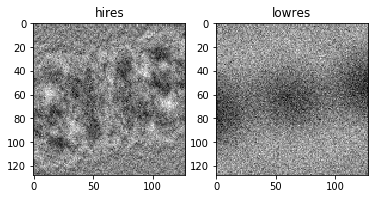

In [46]:
fig = plt.figure()
a = fig.add_subplot(121)
a.set_title('hires')
plt.imshow(stack[0],cmap='gray')

a = fig.add_subplot(122)
a.set_title('lowres')
plt.imshow(stack[-1],cmap='gray')

In [47]:
o_x_train = stack
o_y_train = np.append(np.zeros(num),np.ones(num))
#np.random.shuffle(o_y_train) # garble labels to check if evaluation accuracy is 50%

In [48]:
x_train, x_val, y_train, y_val = train_test_split(o_x_train, o_y_train,
                                                  test_size=0.1,
                                                  random_state=20) # does random shuffle for us

y_train_targ = pd.get_dummies(y_train)
y_val_targ = pd.get_dummies(y_val)

x_train = x_train[:,:,:,np.newaxis]
x_val = x_val[:,:,:,np.newaxis]


print('The Training set images have this shape: ' + str(x_train.shape))
print('The Training set labels have this shape: ' + str(y_train_targ.shape))
print('The Validation set images have this shape: ' + str(x_val.shape))
print('The Validation set labels have this shape: ' + str(y_val_targ.shape))

The Training set images have this shape: (900, 128, 128, 1)
The Training set labels have this shape: (900, 2)
The Validation set images have this shape: (100, 128, 128, 1)
The Validation set labels have this shape: (100, 2)


### set up model
- this code came from a CNN used on mnist handwritten digits, of size $28^2$
- see the architecture in the Deep Consensus paper (Table 1 in doi:10.1107/S2052252518014392)
- try to get the number of training params to be ~1000s, so that the number of examples is an order of magnitude greater (~10k)

In [9]:
from keras.layers import Conv2D, MaxPooling2D, Flatten

model = Sequential()
model.add(Conv2D(4, kernel_size=(3,3), input_shape=x_train.shape[1::], activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(4, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
n_classes = np.unique(o_y_train.tolist()).size
model.add(Dense(n_classes, activation='softmax'))

model.summary()

model.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 378, 378, 4)       40        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 189, 189, 4)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 187, 187, 4)       148       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 93, 93, 4)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 34596)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                345970    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 22        
Total para

### fit and evaluate model

In [10]:
model.fit(x_train, y_train_targ.values, epochs=10, batch_size=int(x_train.shape[0]/100))


scores = model.evaluate(x_val, y_val_targ.values)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

Epoch 1/10
900/900 [==============================] - 19s 21ms/step - loss: 0.2273 - categorical_accuracy: 0.9522
Epoch 2/10
900/900 [==============================] - 19s 21ms/step - loss: 0.0054 - categorical_accuracy: 1.0000
Epoch 3/10
900/900 [==============================] - 19s 22ms/step - loss: 0.0019 - categorical_accuracy: 1.0000
Epoch 4/10
900/900 [==============================] - 19s 21ms/step - loss: 0.0011 - categorical_accuracy: 1.0000
Epoch 5/10
900/900 [==============================] - 19s 21ms/step - loss: 7.5847e-04 - categorical_accuracy: 1.0000
Epoch 6/10
900/900 [==============================] - 18s 21ms/step - loss: 5.7329e-04 - categorical_accuracy: 1.0000
Epoch 7/10
900/900 [==============================] - 19s 21ms/step - loss: 4.5727e-04 - categorical_accuracy: 1.0000
Epoch 8/10
900/900 [==============================] - 19s 21ms/step - loss: 3.7807e-04 - categorical_accuracy: 1.0000
Epoch 9/10
900/900 [==============================] - 19s 21ms/step - lo

### larger kernels

In [34]:
model = Sequential()
model.add(Conv2D(4, kernel_size=(15,15), input_shape=x_train.shape[1::], activation='relu', padding='same'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(4, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
n_classes = np.unique(o_y_train.tolist()).size
model.add(Dense(n_classes, activation='softmax'))

model.summary()

model.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 380, 380, 4)       904       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 190, 190, 4)       0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 188, 188, 4)       148       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 94, 94, 4)         0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 35344)             0         
_________________________________________________________________
dense_23 (Dense)             (None, 10)                353450    
_________________________________________________________________
dense_24 (Dense)             (None, 2)                 22        
Total para

In [35]:
model.fit(x_train, y_train_targ.values, epochs=3, batch_size=int(x_train.shape[0]/100))




Epoch 1/3
900/900 [==============================] - 330s 367ms/step - loss: 0.1297 - categorical_accuracy: 0.9400
Epoch 2/3
900/900 [==============================] - 337s 375ms/step - loss: 0.0020 - categorical_accuracy: 1.0000
Epoch 3/3
900/900 [==============================] - 336s 374ms/step - loss: 8.7033e-04 - categorical_accuracy: 1.0000


In [36]:
scores = model.evaluate(x_val, y_val_targ.values)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

100/100 [==============================] - 11s 113ms/step

categorical_accuracy: 100.00%


In [37]:
model = Sequential()
#2
# 1808 = (15*15+1)*8
# plus one for bias
model.add(Conv2D(4, kernel_size=(15,15), activation='relu',input_shape=x_train.shape[1::], padding='same'))
model.add(MaxPooling2D((2,2)))
#3
model.add(Conv2D(4, kernel_size=(15,15),padding='same'))
# see https://stackoverflow.com/questions/34716454/where-do-i-call-the-batchnormalization-function-in-keras
# not sure if batch normaliztion + relu or relu + batch normaliztion
model.add(BatchNormalization())
model.add(Activation('relu'))

#4
model.add(MaxPooling2D((7,7), strides=2,padding='same'))


###
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dropout(rate=0.5)) # note large dropout rate
n_classes = np.unique(o_y_train.tolist()).size
model.add(Dense(n_classes, activation='softmax'))

model.summary()

model.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 380, 380, 4)       904       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 190, 190, 4)       0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 190, 190, 4)       3604      
_________________________________________________________________
batch_normalization_11 (Batc (None, 190, 190, 4)       16        
_________________________________________________________________
activation_12 (Activation)   (None, 190, 190, 4)       0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 95, 95, 4)         0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 36100)             0         
__________

In [38]:
model.fit(x_train, y_train_targ.values, epochs=3, batch_size=int(x_train.shape[0]/100))




Epoch 1/3
900/900 [==============================] - 463s 514ms/step - loss: 5.8126 - categorical_accuracy: 0.5744
Epoch 2/3
900/900 [==============================] - 464s 516ms/step - loss: 6.2049 - categorical_accuracy: 0.5511
Epoch 3/3
900/900 [==============================] - 462s 513ms/step - loss: 6.1222 - categorical_accuracy: 0.5800


In [39]:
scores = model.evaluate(x_val, y_val_targ.values)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

100/100 [==============================] - 16s 164ms/step

categorical_accuracy: 50.00%


In [50]:
model = Sequential()
#2
# 1808 = (15*15+1)*8
# plus one for bias
model.add(Conv2D(8, kernel_size=(15,15), activation='relu',input_shape=x_train.shape[1::], padding='same'))
#3
model.add(Conv2D(8, kernel_size=(15,15),padding='same'))
# see https://stackoverflow.com/questions/34716454/where-do-i-call-the-batchnormalization-function-in-keras
# not sure if batch normaliztion + relu or relu + batch normaliztion
model.add(Activation('relu'))
model.add(BatchNormalization())

#4
model.add(MaxPooling2D((7,7), strides=2,padding='same'))
#5 
model.add(Conv2D(8, kernel_size=(7,7), activation='relu',padding='same'))
#6
model.add(Conv2D(16, kernel_size=(7,7),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

#7
model.add(MaxPooling2D((5,5), strides=2,padding='same'))
#8 
model.add(Conv2D(32, kernel_size=(3,3), activation='relu',padding='same'))
#9
model.add(Conv2D(32, kernel_size=(3,3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

#10
model.add(MaxPooling2D((3,3), strides=2,padding='same'))
#11
model.add(Conv2D(64, kernel_size=(3,3), activation='relu',padding='same'))
#12
model.add(Conv2D(64, kernel_size=(3,3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

#13
model.add(AveragePooling2D(pool_size=(4, 4), strides=2,padding='same'))
###
model.add(Flatten())
model.add(Dense(512, activation='relu')) # 2097664 = 512*(8*8*64) ; AveragePooling2D size is 8*8*64=4096
model.add(Dropout(rate=0.5)) # note large dropout rate

n_classes = np.unique(o_y_train.tolist()).size
model.add(Dense(n_classes, activation='softmax'))

model.summary()

model.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 128, 128, 8)       1808      
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 128, 128, 8)       14408     
_________________________________________________________________
activation_25 (Activation)   (None, 128, 128, 8)       0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 128, 128, 8)       32        
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 64, 64, 8)         3144      
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 64, 64, 16)        6288      
__________

In [51]:
model.fit(x_train, y_train_targ.values, epochs=3, batch_size=int(x_train.shape[0]/100))




Epoch 1/3
900/900 [==============================] - 132s 146ms/step - loss: 0.0102 - categorical_accuracy: 0.9956
Epoch 2/3
900/900 [==============================] - 123s 137ms/step - loss: 4.9964e-04 - categorical_accuracy: 1.0000
Epoch 3/3
900/900 [==============================] - 122s 136ms/step - loss: 5.3919e-04 - categorical_accuracy: 1.0000


In [53]:
scores = model.evaluate(x_val, y_val_targ.values)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

100/100 [==============================] - 4s 44ms/step

categorical_accuracy: 100.00%
